In [1]:
import pandas as pd
pd.set_option('display.max_rows', 1000)  # or 1000
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn as sns

import pingouin as pg
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import linregress

import dabest
from scipy.stats import chi2_contingency
from scipy.stats import zscore
from scipy.signal import find_peaks

# Data preparation

In [17]:
comps = pd.read_feather('/Users/Oliver/Google Drive/hippnac/data/final_submission/comps.feather')
C = pd.read_hdf('/Users/Oliver/Google Drive/hippnac/data/final_submission/C.h5', 'C')
psth_ds = pd.read_feather('/Users/Oliver/Google Drive/hippnac/data/final_submission/psth_ds.feather')
behaviour = pd.read_hdf('/Users/Oliver/Google Drive/hippnac/data/final_submission/375_behaviour.h5', 'behaviour')

# Fig 6A

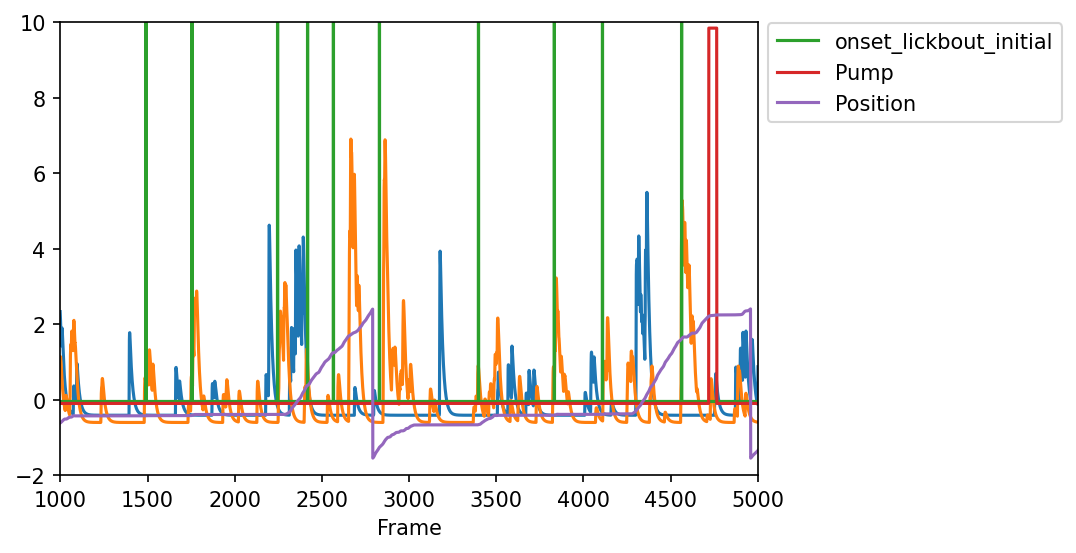

In [3]:
exp = 143

behaviour_exp = behaviour.loc[exp].copy()
behaviour_exp.Licking = behaviour_exp.Licking / behaviour_exp.Licking.max()
behaviour_exp['Licks'] = 0
behaviour_exp.loc[behaviour_exp.index[find_peaks(behaviour_exp.Licking, height=behaviour_exp.Licking.std()*0.75, distance=10)[0]], 'Licks'] = 1
behaviour_exp['LickBouts'] = (behaviour_exp.Licks.rolling(30).mean()>0).astype(int)
idx = {}
idx['onset_lickbout'] = behaviour_exp.index[behaviour_exp.LickBouts.astype(int).diff()==1].to_list()
idx['onset_lickbout_initial'] = [i for i in idx['onset_lickbout'] if (behaviour_exp.loc[behaviour_exp.index[i-90:i], 'Licks'].sum()==0)&(i>90)] # lickbouton_initial (first lick after >5sec not licking)
behaviour_exp[['onset_lickbout', 'onset_lickbout_initial']] = 0
behaviour_exp.loc[idx['onset_lickbout_initial'], 'onset_lickbout_initial'] = 1
behaviour_exp.loc[idx['onset_lickbout'], 'onset_lickbout'] = 1

fig, ax = plt.subplots(1,1)
C[exp][[11, 118]].dropna().apply(zscore).plot(ax=ax)
behaviour_exp[['onset_lickbout_initial', 'Pump', 'Position']].dropna().apply(zscore).plot(ax=ax)
ax.set_xlim([1000, 5000])
ax.set_ylim([-2, 10])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[2:], labels[2:], title='', bbox_to_anchor=(1, 1.02), loc='upper left')

# Fig 6C-D

In [19]:
psth_ds = psth_ds.rename(columns={'CellID':'NeuronID'})
psth_ds['ExpCellID'] = 'e'+psth_ds['ExpID'].apply(lambda x: '{0:0>3}'.format(x)) +'c'+ psth_ds['NeuronID'].apply(lambda x: '{0:0>4}'.format(x))
comps['ExpCellID'] = 'e'+comps['ExpID'].apply(lambda x: '{0:0>3}'.format(x)) +'c'+ comps['NeuronID'].apply(lambda x: '{0:0>4}'.format(x))

In [20]:
if 'ExpID' in psth_ds.columns:
    psth_ds = psth_ds.set_index(['ExpID', 'NeuronID'])
if 'ExpID' in comps.columns:
    comps = comps.set_index(['ExpID', 'NeuronID'])

psth_ds = psth_ds.join(comps[['C_onset_lickbout_initial_pos', 'C_onset_lickbout_initial_neg']]).reset_index()

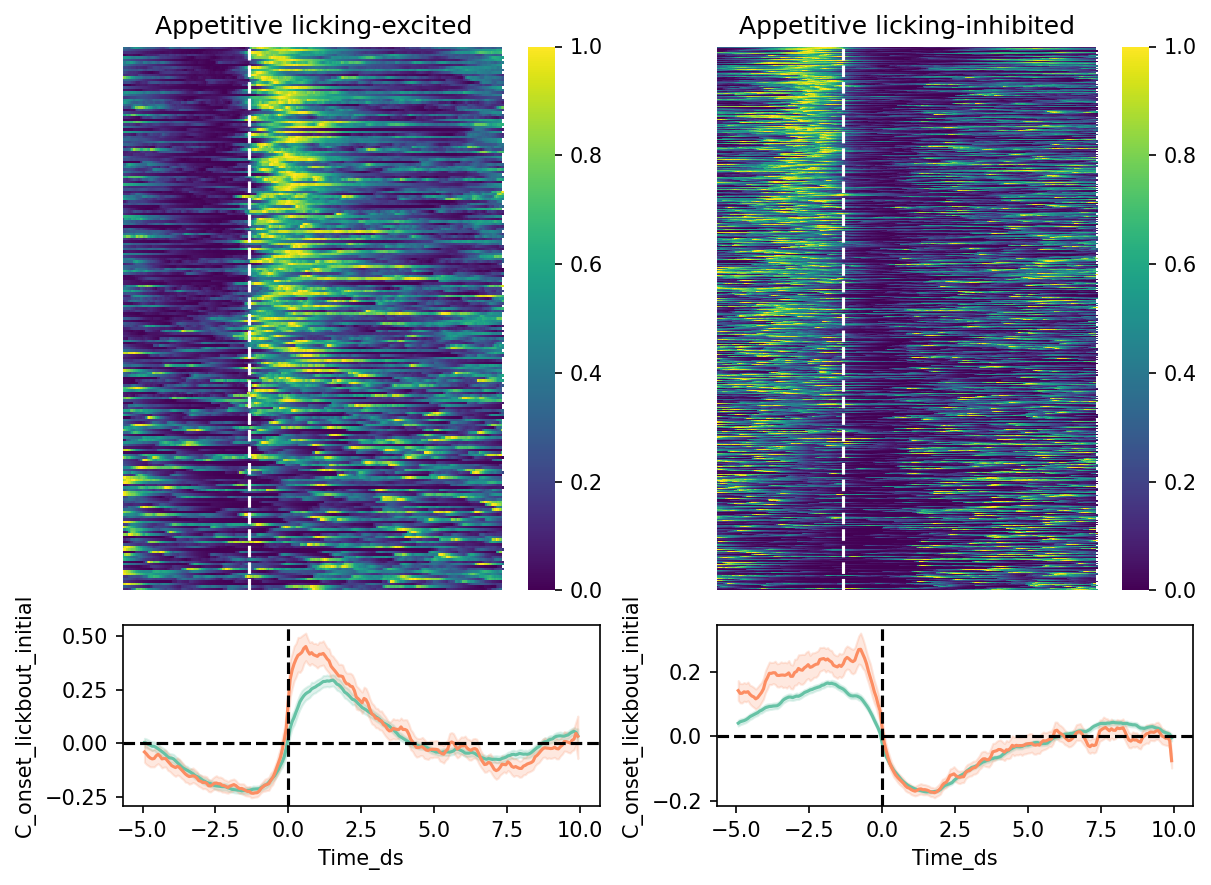

In [48]:
fig, axs = plt.subplots(2,2, figsize=(8,6), gridspec_kw={'height_ratios': [3,1]})

pos_heatmap = psth_ds.loc[
    psth_ds.C_onset_lickbout_initial_pos].pivot_table(
        values='C_onset_lickbout_initial', columns='Time_ds', index='ExpCellID').loc[
            comps.loc[comps.C_onset_lickbout_initial_pos].sort_values('C_onset_lickbout_initial_diff',
                                                                      ascending=False)['ExpCellID'].values]
pos_heatmap_norm = pos_heatmap.sub(pos_heatmap.min(axis=1), axis=0)
pos_heatmap_norm = pos_heatmap_norm.div(pos_heatmap_norm.max(axis=1), axis=0)
sns.heatmap(pos_heatmap_norm, cmap='viridis', ax=axs[0,0])
axs[0,0].axis('off')
axs[0,0].axvline(74, ls='--', c='w')
axs[0,0].set_title('Appetitive licking-excited')

neg_heatmap = psth_ds.loc[
    psth_ds.C_onset_lickbout_initial_neg].pivot_table(
        values='C_onset_lickbout_initial', columns='Time_ds', index='ExpCellID').loc[
            comps.loc[comps.C_onset_lickbout_initial_neg].sort_values('C_onset_lickbout_initial_diff',
                                                                      ascending=True)['ExpCellID'].values]
neg_heatmap_norm = neg_heatmap.sub(neg_heatmap.min(axis=1), axis=0)
neg_heatmap_norm = neg_heatmap_norm.div(neg_heatmap_norm.max(axis=1), axis=0)
sns.heatmap(neg_heatmap_norm, cmap='viridis', ax=axs[0,1])
axs[0,1].axis('off')
axs[0,1].axvline(74, ls='--', c='w')
axs[0,1].set_title('Appetitive licking-inhibited')

sns.lineplot(data=psth_ds.loc[psth_ds.C_onset_lickbout_initial_pos], legend=None,
             x='Time_ds', y='C_onset_lickbout_initial', ci=68, palette='Set2',
             hue='Red', ax=axs[1, 0])
axs[1,0].axvline(0, ls='--', c='k')
axs[1,0].axhline(0, ls='--', c='k')

sns.lineplot(data=psth_ds.loc[psth_ds.C_onset_lickbout_initial_neg], legend=None,
             x='Time_ds', y='C_onset_lickbout_initial', ci=68, palette='Set2',
             hue='Red', ax=axs[1, 1])
axs[1,1].axvline(0, ls='--', c='k')
axs[1,1].axhline(0, ls='--', c='k')

fig.tight_layout()

# Fig 6E

/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='C_onset_lickbout_initial_pos'>

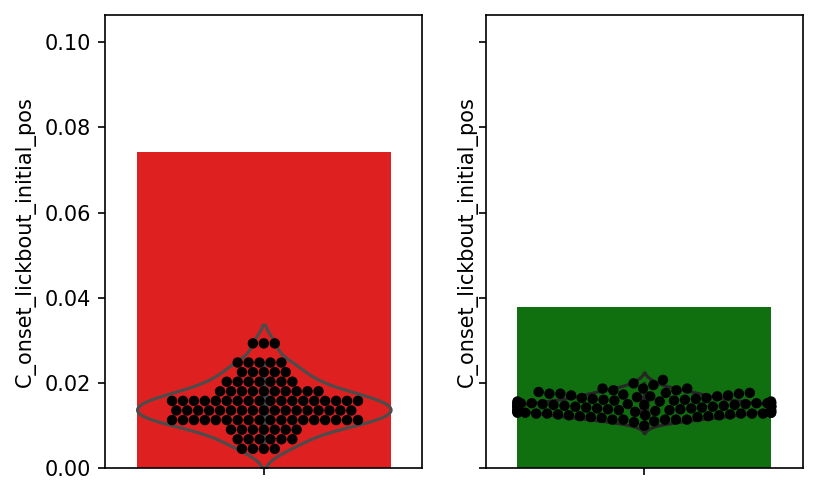

In [65]:
fig, axs = plt.subplots(1,2, sharey=True)
sns.barplot(data=comps[comps.Red], y='C_onset_lickbout_initial_pos', errwidth=0, ax=axs[0], color='r')
sns.violinplot(y=comps[comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_pos'
                                         ).mean(axis=0), color='r', ax=axs[0])
sns.swarmplot(y=comps[comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_pos'
                                         ).mean(axis=0), color='k', ax=axs[0])

sns.barplot(data=comps[~comps.Red], y='C_onset_lickbout_initial_pos', errwidth=0, ax=axs[1], color='g')
sns.violinplot(y=comps[~comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_pos'
                                         ).mean(axis=0), color='g', ax=axs[1])
sns.swarmplot(y=comps[~comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_pos'
                                         ).mean(axis=0), color='k', ax=axs[1])

# Fig 6F

/Users/Oliver/miniconda3/envs/hippnac/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 15.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:ylabel='C_onset_lickbout_initial_neg'>

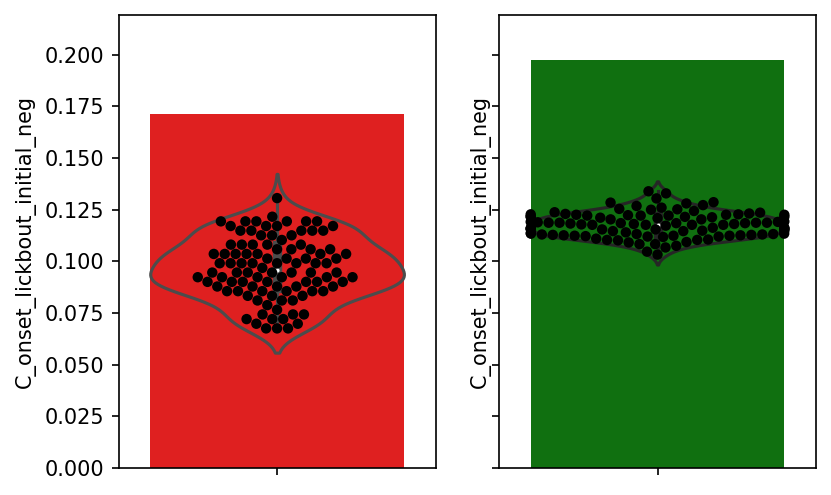

In [68]:
fig, axs = plt.subplots(1,2, sharey=True)
sns.barplot(data=comps[comps.Red], y='C_onset_lickbout_initial_neg', errwidth=0, ax=axs[0], color='r')
sns.violinplot(y=comps[comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_neg'
                                         ).mean(axis=0), color='r', ax=axs[0])
sns.swarmplot(y=comps[comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_neg'
                                         ).mean(axis=0), color='k', ax=axs[0])

sns.barplot(data=comps[~comps.Red], y='C_onset_lickbout_initial_neg', errwidth=0, ax=axs[1], color='g')
sns.violinplot(y=comps[~comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_neg'
                                         ).mean(axis=0), color='g', ax=axs[1])
sns.swarmplot(y=comps[~comps.Red].filter(regex='C_onset_lickbout_initial_shuffle_neg'
                                         ).mean(axis=0), color='k', ax=axs[1])